# Functions to get the Aggregates Price Changes

In [64]:
def generate_readable_timestamps(interval_minutes):
    """
    Generates a list of readable timestamps for a given time interval.

    Args:
    - interval_minutes (int): The time interval in minutes.

    Returns:
    - list: A list of readable timestamps.
    """
    readable_timestamps = []
    for hour in range(24):
        for minute in range(0, 60, interval_minutes):
            timestamp = f"{hour:02d}:{minute:02d}"
            readable_timestamps.append(timestamp)
    return readable_timestamps

# Example usage:
readable_timestamps = generate_readable_timestamps(interval_minutes=15)

In [65]:
def fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes):
    """
    Fetches aggregated volumes and calculates price volatility for the given stock ticker and date range.

    Args:
    - ticker (str): The stock ticker symbol.
    - start_date (str): The start date in the format 'YYYY-MM-DD'.
    - end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    - dict: A dictionary containing aggregated volumes, number of trades, and price volatility with timestamps as keys.
    """
    # API query parameters
    api_key = "RLH5skiQVl24hXBE2IyPT3JBDmorI4r0"
    readable_timestamps = generate_readable_timestamps(interval_minutes)


    # Initialize a dictionary to store volumes, number of trades, and price volatility for each timestamp
    stock_data = {timestamp: {'abs_change': [], 'max_diff': []} for timestamp in readable_timestamps}
    
    # Construct API query URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{interval_minutes}/minute/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"

    # Make the API request
    response = requests.get(url)
    
    averages = {}

    # Check if the request was successful
    if response.status_code == 200:
        # Load JSON data from the response
        data = response.json()
        results = data["results"]

        # Iterate through results and convert timestamps to readable times
        for result in results:
            timestamp = result["t"]
            num_trades = result["n"]
            high = result["h"]
            low = result["l"]
            open_price = result["o"]
            close = result["c"]
            abs_change = abs(open_price - close)
            max_diff = abs(high - low)
            timestamp_et = pd.to_datetime(timestamp, unit='ms', utc=True).tz_convert('America/New_York')
            timestamp_str = timestamp_et.strftime("%H:%M")
            
            # Append volume and number of trades to the corresponding timestamp
            stock_data[timestamp_str]['abs_change'].append(abs_change)
            stock_data[timestamp_str]['max_diff'].append(max_diff)
            
        for timestamp, data in stock_data.items():
            if len(data['abs_change']) > 0:
                average_change = sum(data['abs_change']) / len(data['abs_change'])
                average_diff = sum(data['max_diff']) / len(data['max_diff'])
                averages[timestamp] = {"abs_change": average_change, "max_diff": average_diff}

    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

    return averages


def plot_pc_histogram(metrics, ticker):
    """
    Plots histograms of average price change and maximum difference for each interval of the day.

    Args:
    - metrics (dict): A dictionary containing average price change and maximum difference with timestamps as keys.
    """
    timestamps = list(metrics.keys())
    average_abs_change = [data["abs_change"] for data in metrics.values()]
    average_max_diff = [data["max_diff"] for data in metrics.values()]

    # Create a figure and axis objects for two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot the average price change histogram
    ax1.bar(range(len(timestamps)), average_abs_change, width=0.4, color='skyblue', label='Average Abs. Change')
    ax1.set_ylabel('Average Price Change')
    ax1.set_title(f'Average Price Change for Each Interval of the Day - {ticker}')
    ax1.set_xticks(range(len(timestamps)))  # Set x-axis ticks to numerical values
    ax1.set_xticklabels(timestamps, rotation=90)  # Set x-axis tick labels to timestamps

    # Plot the maximum difference histogram on the second subplot
    ax2.bar(range(len(timestamps)), average_max_diff, width=0.4, color='orange', alpha=0.7, label='Average Max. Difference')
    ax2.set_ylabel('Average Max. Difference')
    ax2.set_title(f'Average Max. Difference for Each Interval of the Day - {ticker}')
    ax2.set_xticks(range(len(timestamps)))  # Set x-axis ticks to numerical values
    ax2.set_xticklabels(timestamps, rotation=90)  # Set x-axis tick labels to timestamps

    # Show grid
    ax1.grid(axis='y')
    ax2.grid(axis='y')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


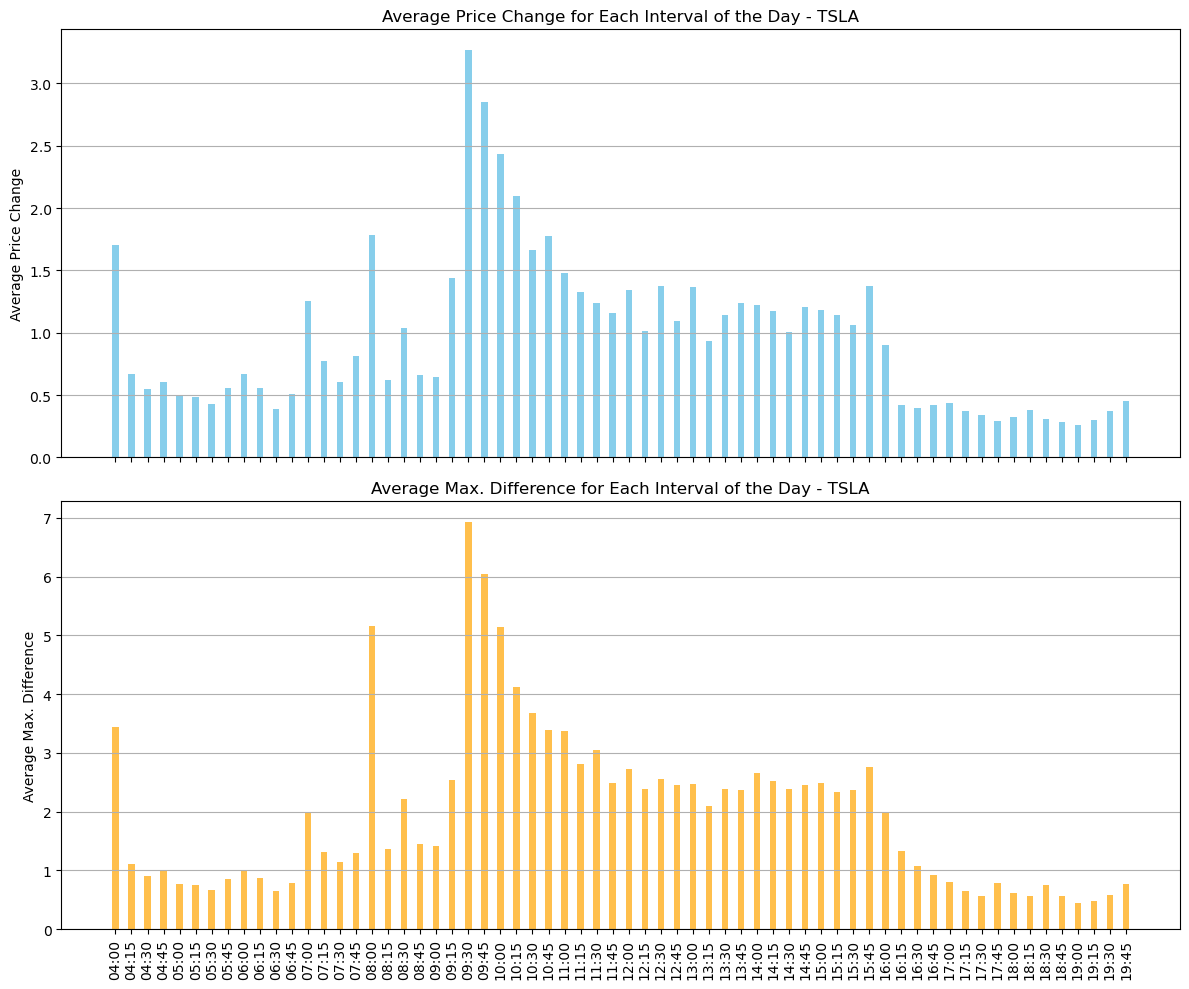

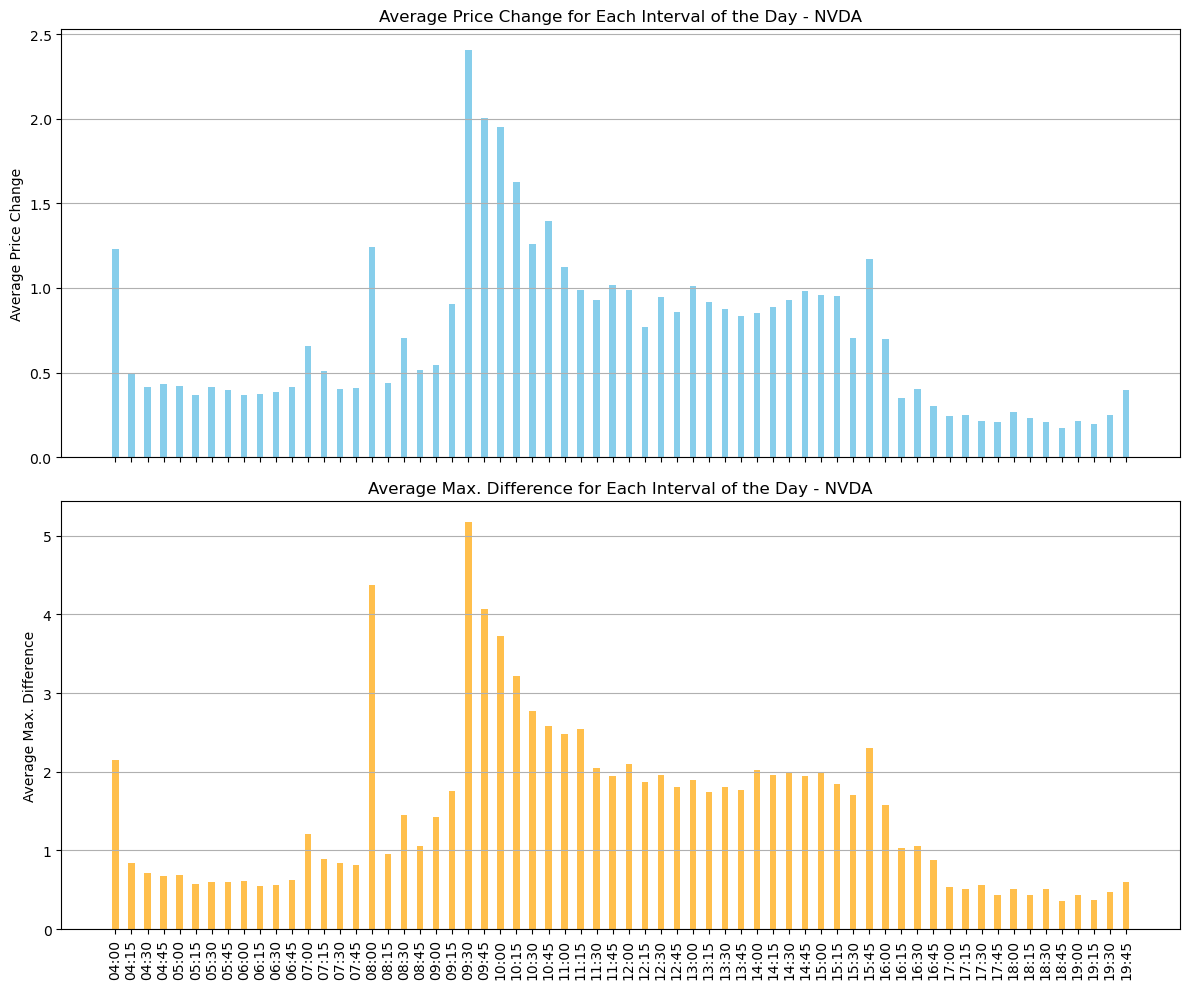

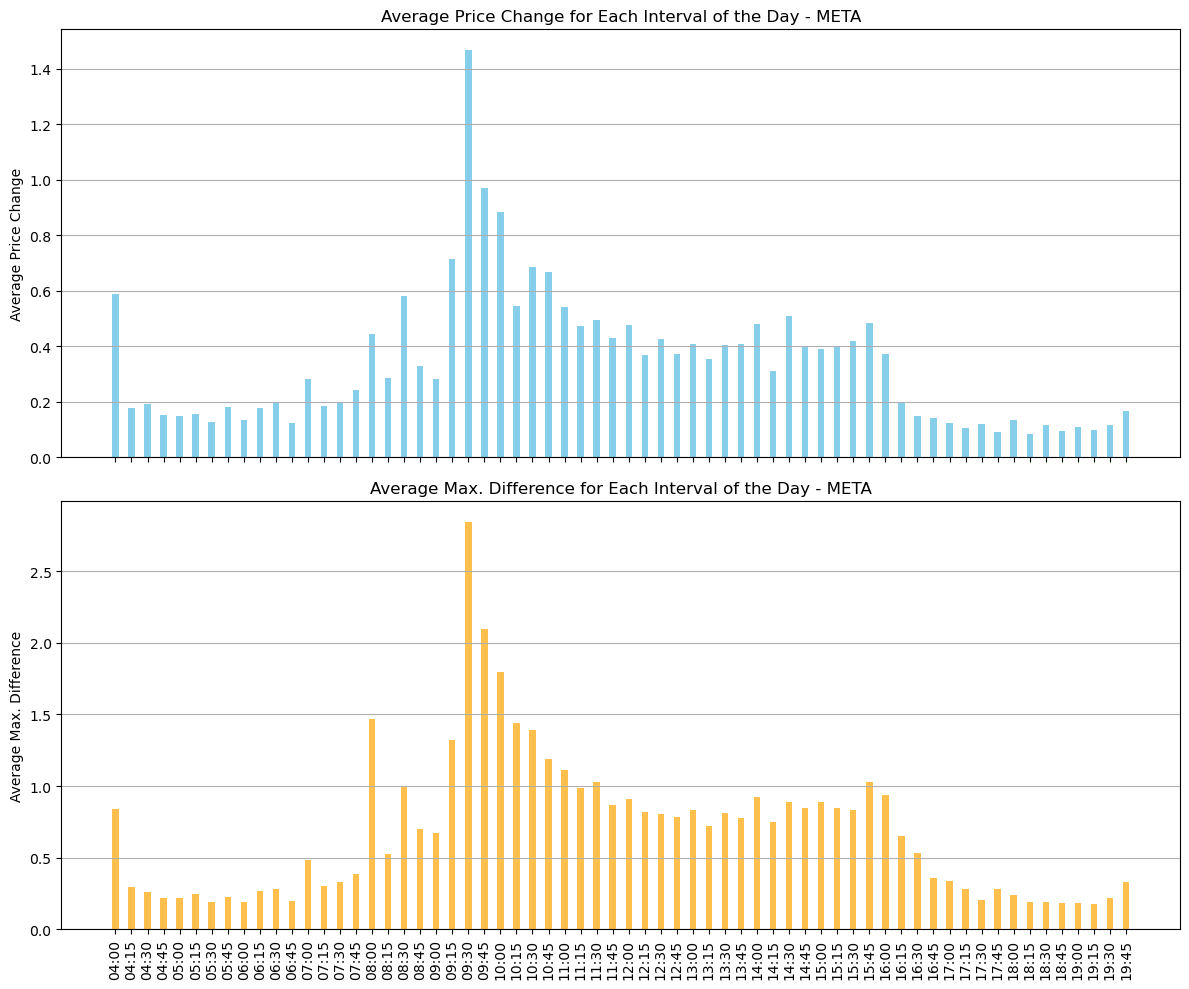

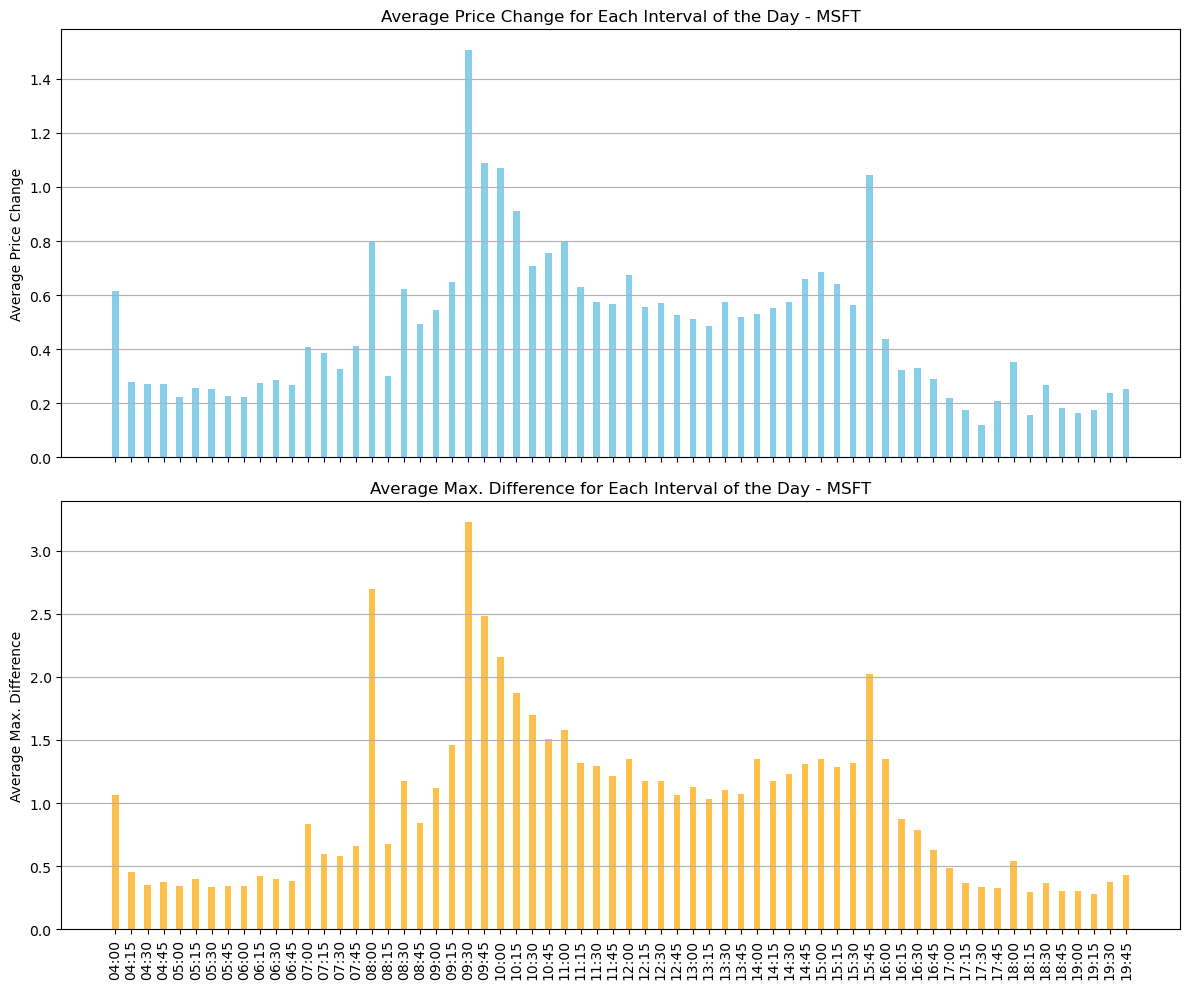

In [66]:
start_date = "2018-01-01"
end_date =  "2024-02-16"
interval_minutes = 15
high_vol = ['TSLA', 'NVDA', 'META', 'MSFT']
for ticker in high_vol:
    averages = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)
    plot_pc_histogram(averages, ticker)

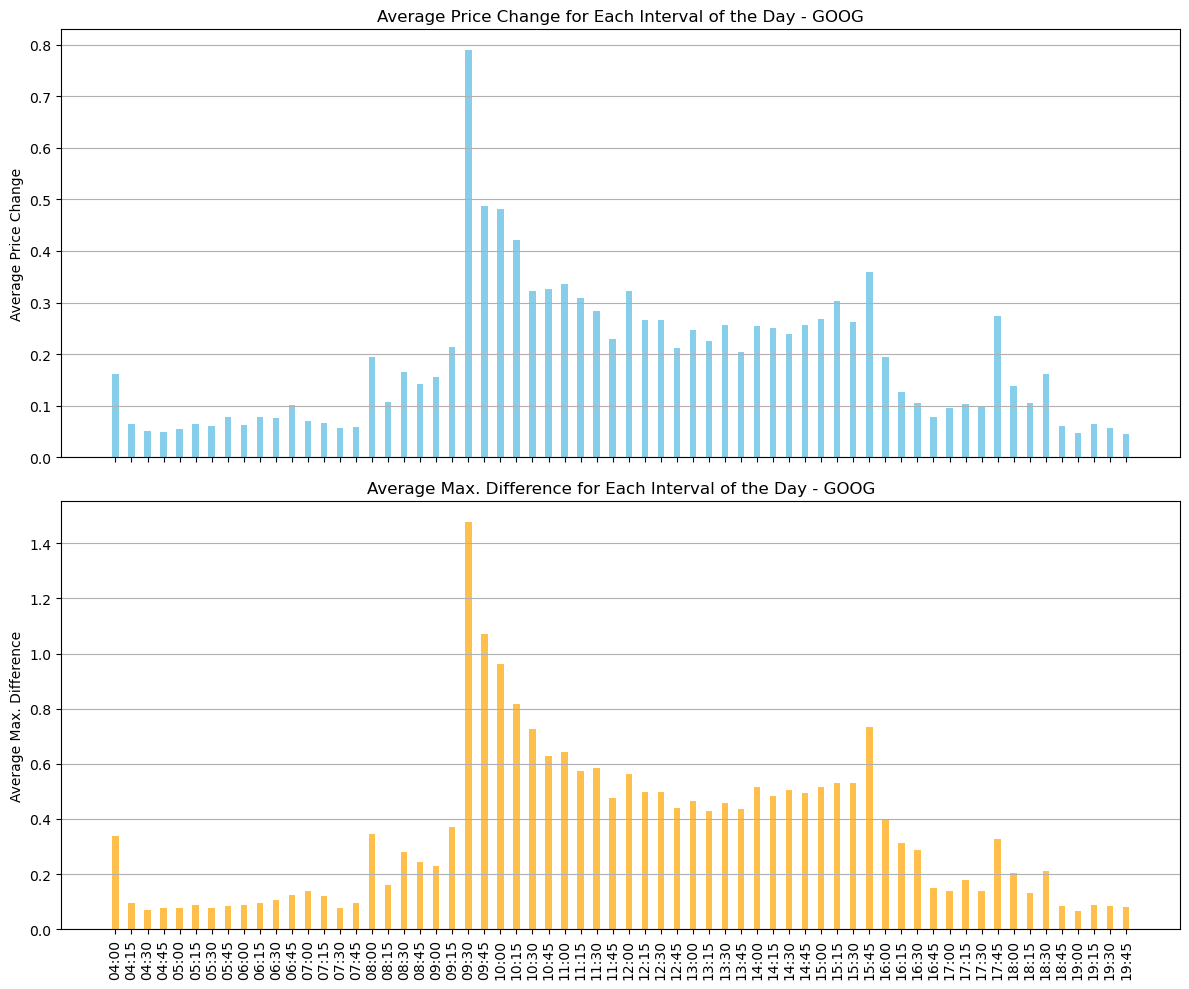

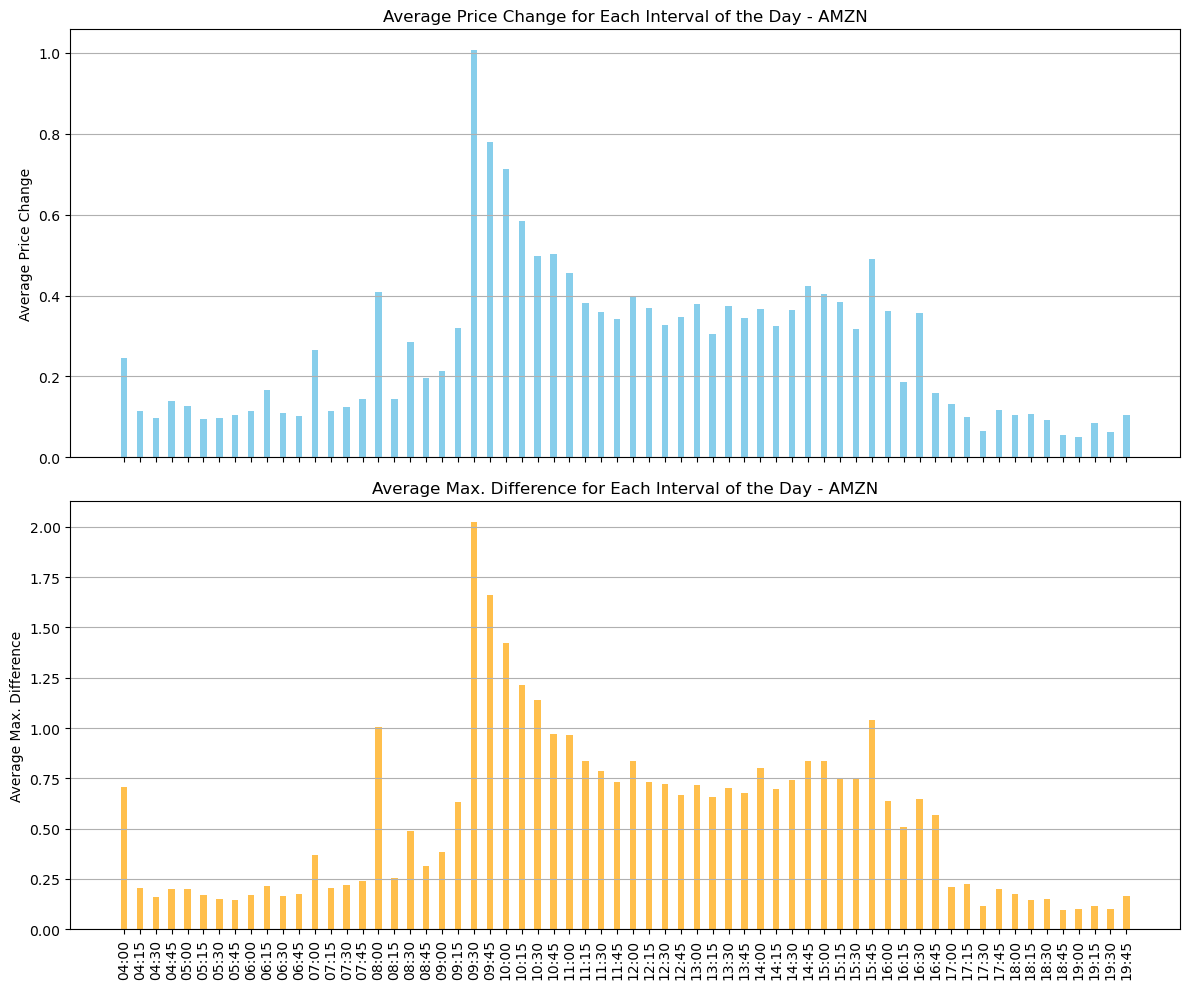

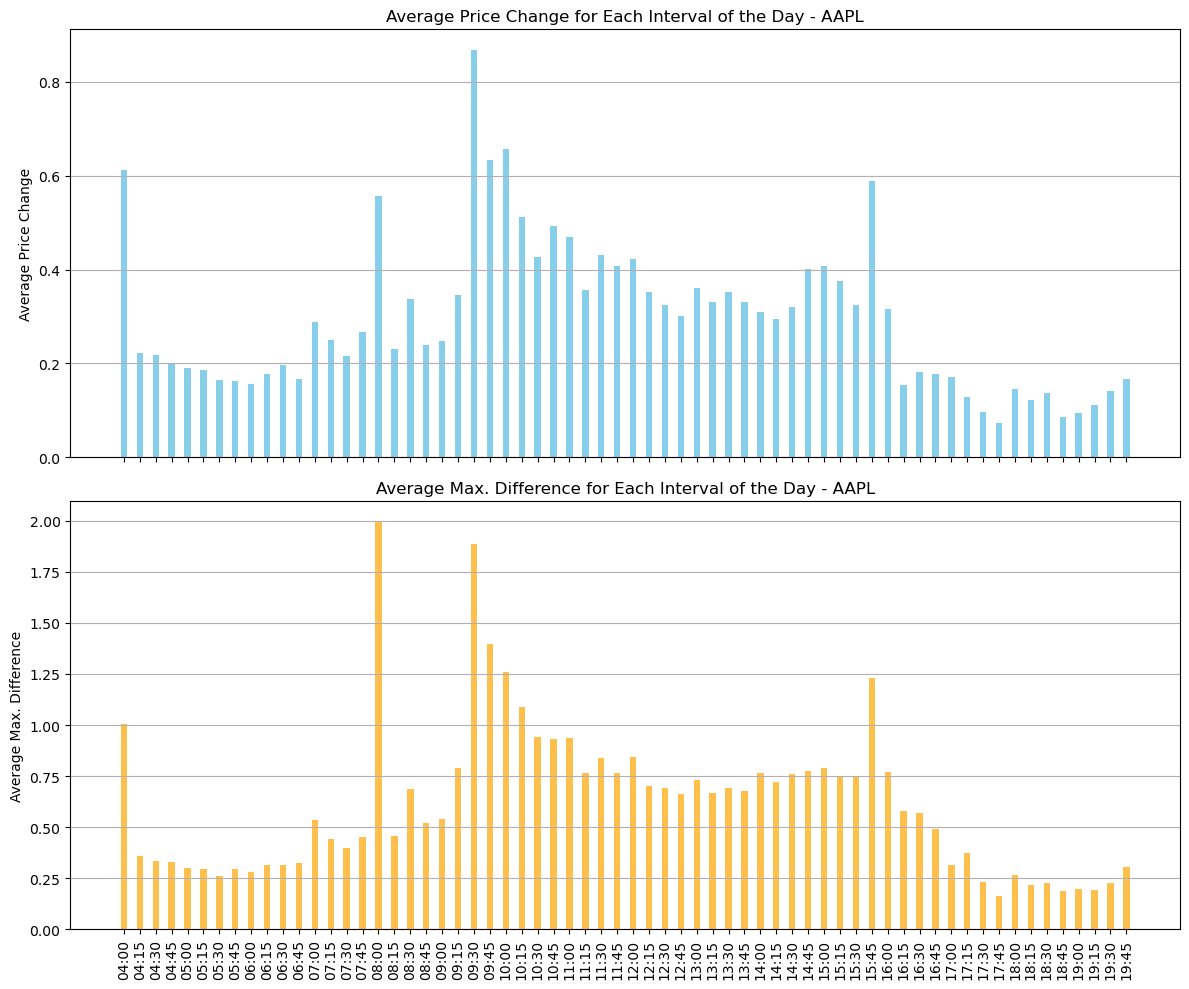

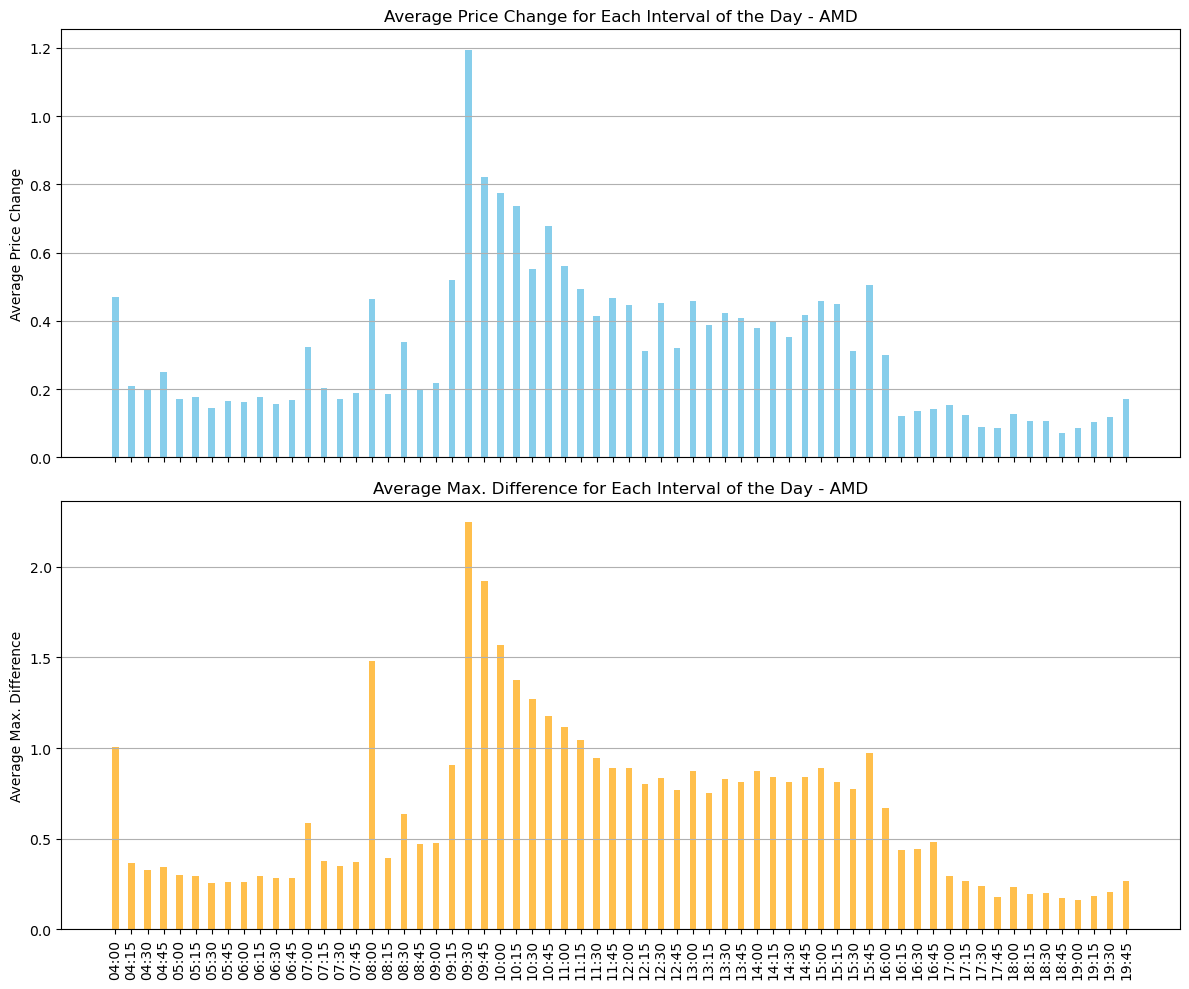

In [87]:
low_vol = ['GOOG', 'AMZN', 'AAPL', 'AMD']
for ticker in low_vol:
    averages = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)
    plot_pc_histogram(averages, ticker)

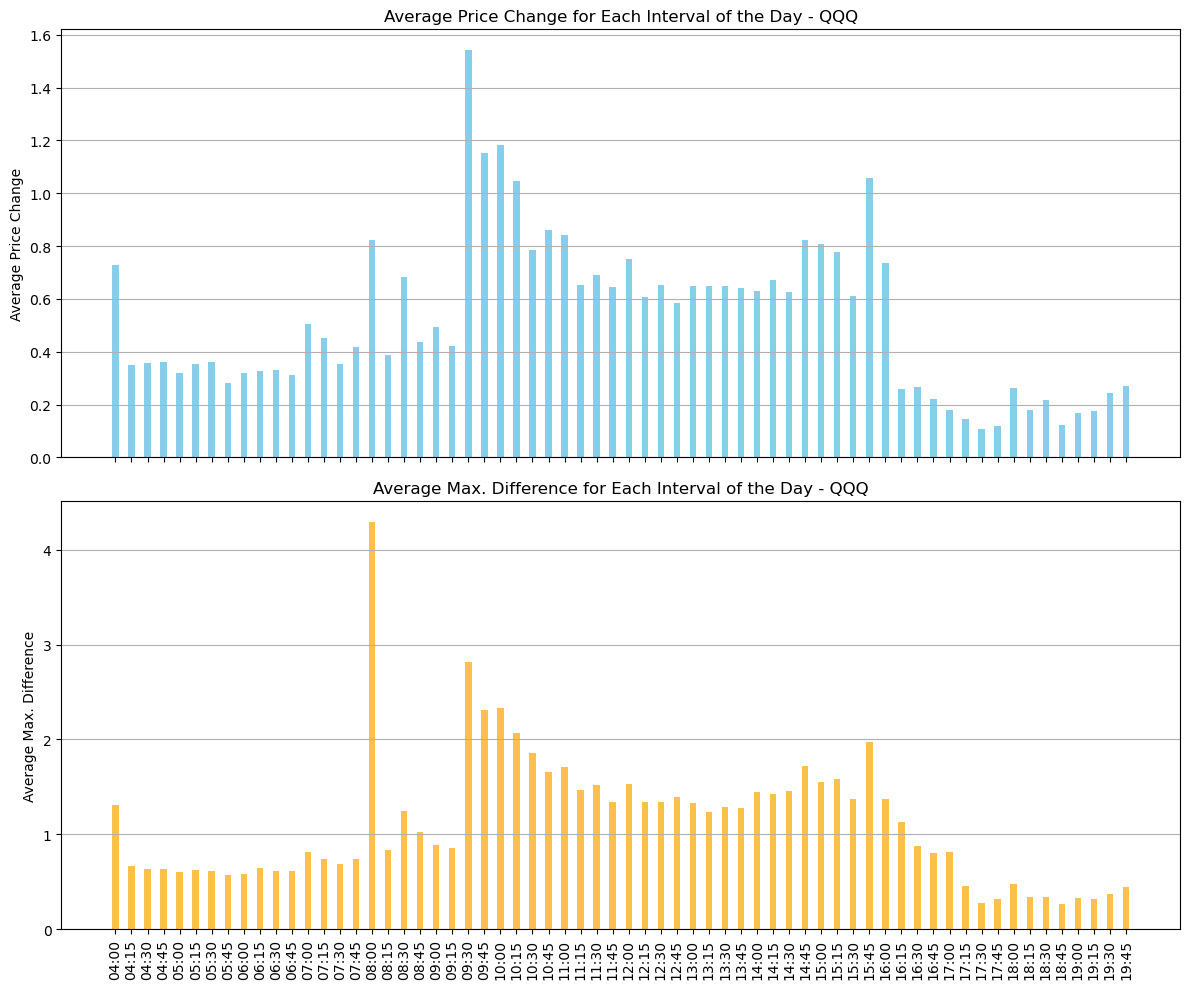

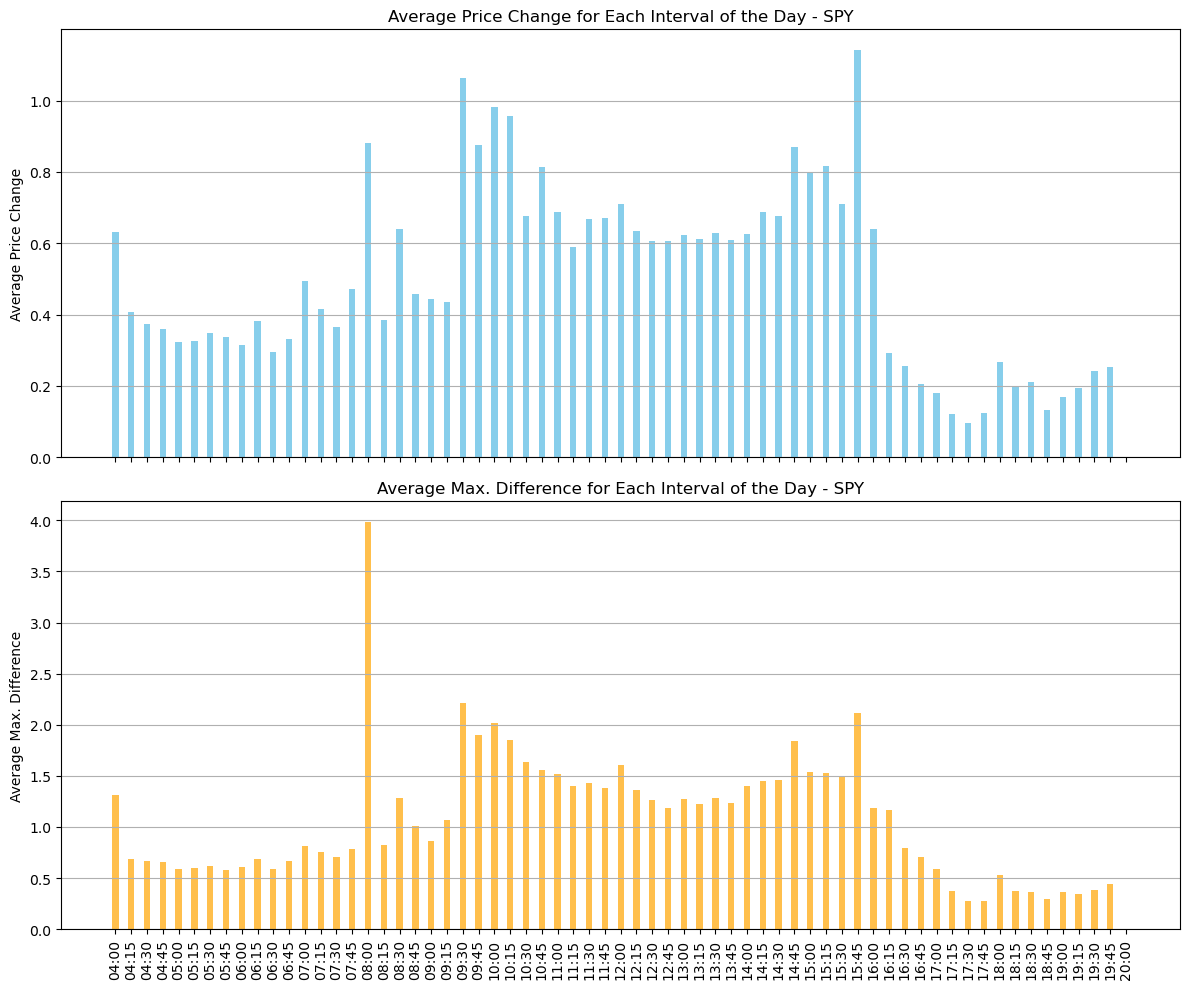

In [68]:
etf = ['QQQ', 'SPY']
for ticker in etf:
    averages = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)
    plot_pc_histogram(averages, ticker)

In [82]:
import numpy as np

def analyze_metrics(metrics, threshold):
    """
    Analyzes the metrics for each 15-minute interval and returns times above a certain threshold.

    Args:
    - metrics (dict): A dictionary containing aggregated price change and maximum difference with timestamps as keys.
    - threshold (float): The absolute threshold value for both price change and maximum difference significance.

    Returns:
    - list: A list of timestamps where both price change and maximum difference significance are above the threshold.
    """
    significant_times = []


    # Extract the average price change and maximum difference from the input dictionary
    average_change = np.array([data["abs_change"] for data in metrics.values() if data["abs_change"] is not None])
    average_diff = np.array([data["max_diff"] for data in metrics.values() if data["max_diff"] is not None])

    if len(average_change) == 0 or len(average_diff) == 0:
        return significant_times  # Return empty list if no data available

    # Calculate overall average and standard deviation for price change
    overall_average_change = np.mean(average_change)
    overall_std_change = np.std(average_change)

    # Calculate overall average and standard deviation for maximum difference
    overall_average_diff = np.mean(average_diff)
    overall_std_diff = np.std(average_diff)

    # Calculate statistical significance for price change
    change_significance = (average_change - overall_average_change) / overall_std_change

    # Calculate statistical significance for maximum difference
    diff_significance = (average_diff - overall_average_diff) / overall_std_diff

    # Check if both price change and maximum difference significance are above the threshold
    # and add corresponding times to the list
    for i, timestamp in enumerate(metrics.keys()):
        if abs(change_significance[i]) > threshold and abs(diff_significance[i]) > threshold:
            significant_times.append(timestamp)

    return significant_times


In [83]:
high_vol = ['TSLA', 'NVDA', 'META', 'MSFT']
for ticker in high_vol:
    values = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)
    stats = analyze_metrics(values, 1.5)
    print("significant times for " + ticker)
    print(stats)

significant times for TSLA
['09:30', '09:45', '10:00', '10:15']
significant times for NVDA
['09:30', '09:45', '10:00', '10:15']
significant times for META
['09:30', '09:45', '10:00']
significant times for MSFT
['09:30', '09:45', '10:00', '15:45']


In [88]:
low_vol = ['GOOG', 'AMZN', 'AAPL', 'AMD']
for ticker in low_vol:
    values = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)
    stats = analyze_metrics(values, 1.5)
    print("significant times for " + ticker)
    print(stats)

significant times for GOOG
['09:30', '09:45', '10:00', '10:15']
significant times for AMZN
['09:30', '09:45', '10:00', '10:15']
significant times for AAPL
['08:00', '09:30', '09:45', '10:00', '15:45']
significant times for AMD
['09:30', '09:45', '10:00', '10:15']


In [85]:
etf = ['QQQ', 'SPY']
for ticker in etf:
    values = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)
    stats = analyze_metrics(values, 1.5)
    print("significant times for " + ticker)
    print(stats)

significant times for QQQ
['09:30', '09:45', '10:00']
significant times for SPY
['09:30', '10:00', '15:45', '20:00']
